In [8]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

from ultralytics import YOLO
import cv2
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from huggingface_hub import hf_hub_download
from PIL import Image
import torch
import matplotlib.pyplot as plt
import numpy as np

In [9]:
# Load the weights from our repository
model_path = hf_hub_download(repo_id="Daniil-Domino/yolo11x-text-detection", filename="model.pt")
detection_model = YOLO(model_path)

In [10]:
# Load the pretrained model and processor
reading_model_name = "openthaigpt/thai-trocr"
# reading_model_name = 'microsoft/trocr-base-str'
reading_model = VisionEncoderDecoderModel.from_pretrained(reading_model_name,
    use_safetensors=True)
processor = TrOCRProcessor.from_pretrained(reading_model_name,
    use_safetensors=True)

In [11]:
image_path = "./images/comment.png"
image = cv2.imread(image_path).copy()

denoised_image = cv2.fastNlMeansDenoising(image, h=5)

# Auto contrast
def auto_contrast(img):
    # Compute mean intensity
    mean_val = np.mean(img)
    # If image is too dark → brighten
    if mean_val < 110:
        alpha, beta = 2, 40   # more contrast + brightness
    # If image is too bright → darken
    else:
        alpha, beta = 1, -30

    return cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

contrasted_image = auto_contrast(denoised_image)

preprocessed_image = contrasted_image.copy()

In [12]:
output = detection_model.predict(image, conf=0.3)


0: 384x640 58 texts, 660.5ms
Speed: 2.5ms preprocess, 660.5ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)


In [13]:
# Draw bounding boxes
out_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Sort YOLO boxes by (ymin, xmin) so top-to-bottom, left-to-right
boxes = sorted(output[0].boxes.data.tolist(), key=lambda b: (b[1], b[0]))

texts = []

for data in boxes:
    xmin, ymin, xmax, ymax, _, _ = map(int, data)
    crop = out_image[ymin-4:ymax+4, xmin-4:xmax+4]        
    cv2.rectangle(out_image, (xmin-4, ymin-4), (xmax+4, ymax+4), color=(0, 0, 255), thickness=3)
    
    # Convert crop for TrOCR
    pil_crop = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
    inputs = processor(images=pil_crop, return_tensors="pt").to("cpu")
    generated_ids = reading_model.generate(**inputs)
    text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    texts.append(text)
    
print("Detected texts:", texts)


Detected texts: ['ฦ', 'ปักหมญโดย @Theghostradio', 'a', 'HTMLMP6 E', '(แก้ไขแล้ว)', 'เดือนทีผ่านม', 'สุดจริงเรื่องนี้เดอะเบสสุดฯ', 'อัศจรรย์บันดาลนั้น"โปรดภักดีจารณณญ', '๖', '9', 'ฅอบกลับ', '2.7 พัน', 'การตอบกลับ 49 รายการ', 'การตอบกลับ', 'v', '@Phianphen333', '5 เดือนที่ผ่านมา', 'เดือนทัผ่านมา', 'ผู้หญิงช่อรํารักษาโรคและอามหิดสุดสุดจันทร์', 'ากรมหนุนไพละดามดิไปนเสนนาธนนา', 'ตัดภาพยอนไปมาได่เก่งมากา', 'เข้าใจได่', "คุณอาร์มเล่าดีมาก'", 'ทะลุปรุโปร่ง เต็มลงไปเลยค่ะ', 'ทะลุปรุโปร่ง', 'เต็มสิบไปเลยค่ะ', 'ทะลุปรุโปร่', '5', '81', '875', 'ฅอบกลับ', 'การตอบกลับ', 'v', 'รายการ', 'M', 'Waitmaughyn215 เหือนท์มานมา', '@minmaxmember2215 5', 'เค้ารักกันมากน:', 'สงสาร', 'เด็กๆที่ไม่รู้เรื่องเลย', '5', '', 'ตอบกลับ', '423', '5 เดือนที่ผ่านมา', '@jichonsrisaenyong6931', 'ล', 'สดยอดเลยครับเรื่องนี้', 'ดต่อจากต่อฉากได้ยอดเยี่ยมมาก', 'ปมปริศนาค่อยๆ', 'ถ้าเป็นหนังโรงก็ด้องบอกว่า', 'เสดยอดเลยครับเรืองนี', 'เฉลยทีละนิดฯ', 'หL', '5', 'ตอบกลับ', '712', 'การตอบกลับ']


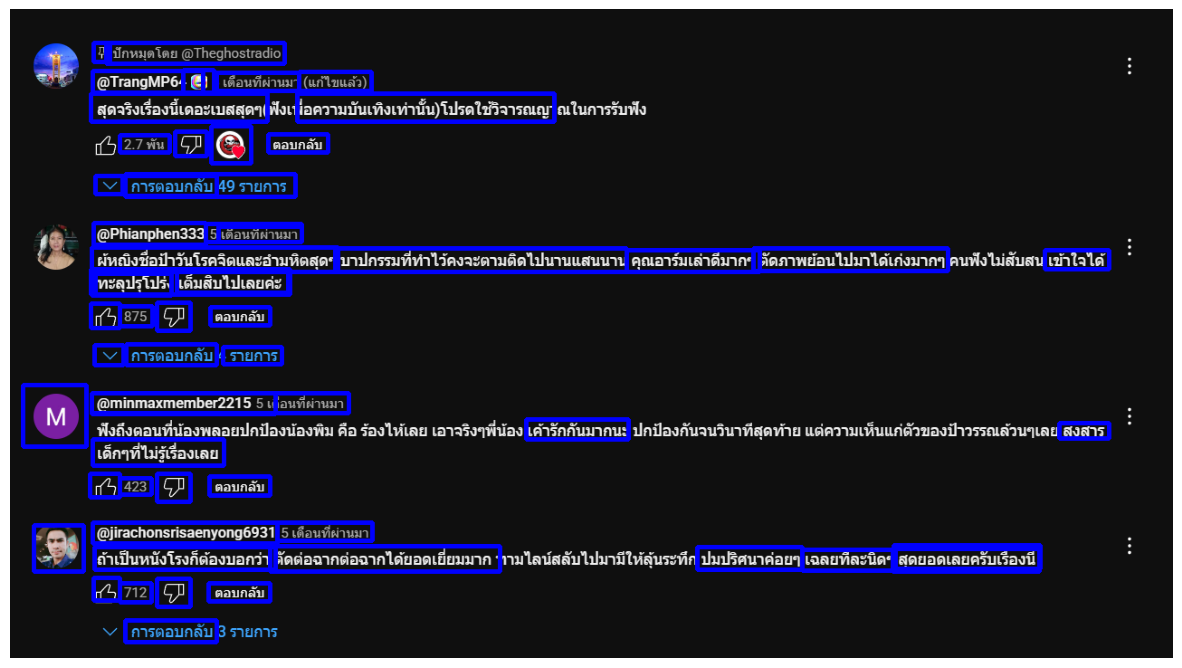

In [14]:
# Display result
plt.figure(figsize=(15, 10))
plt.imshow(out_image)
plt.axis('off')
plt.show()